# 📊 Mô Tả Tập Dữ Liệu (Dataset Description)

## 1. Tổng quan dữ liệu
Tập dữ liệu bao gồm kết quả khảo sát từ **759 người đang đi làm**, tập trung vào các yếu tố ảnh hưởng đến nghề nghiệp và mức độ hài lòng.

| Đặc điểm | Chi tiết |
| :--- | :--- |
| **Số lượng quan sát** | 759 |
| **Số lượng biến** | 241  |
| **Định dạng** | Bảng (Tabular), dữ liệu số |
| **Giá trị khuyết (Null)** | Không phát hiện |
| **Biến mục tiêu** | `p1q9_job_current` (6 nhóm nghề) |

---

## 2. Phân nhóm biến
Các biến trong tập dữ liệu được chia thành các nhóm chính sau:

* **Thông tin nền (Demographics):** Tuổi, loại hình trường đào tạo, dân tộc và các đặc điểm cá nhân khác.
* **Hoạt động hướng nghiệp:** Các hoạt động diễn ra trong thời gian đi học.
* **Yếu tố ảnh hưởng nghề nghiệp:** Đo lường bằng thang đo Likert.
* **Mức độ hài lòng nghề nghiệp:**
    * Gồm 15 câu hỏi thành phần: `q12_rate1` đến `q12_rate15`.
    * **Biến tổng hợp:** `tong12` (Giá trị trung bình của 15 câu hỏi trên).

---

## 3. 🎯 Biến mục tiêu (Target Variable)
* **Tên biến:** `p1q9_job_current`
* **Mô tả:** Biến phân loại gồm 6 nhóm nghề (mã hóa từ `0` đến `5`).
* **⚠️ Lưu ý về phân phối lớp:** Dữ liệu bị **mất cân bằng nghiêm trọng (Imbalanced Data)**.
    * **Nhóm 0:** Chiếm ưu thế (> 50% mẫu).
    * **Nhóm 1–3:** Số lượng trung bình.
    * **Nhóm 4–5:** Rất ít quan sát (đặc biệt Nhóm 5 chiếm < 1%).

---

## 4. Đặc điểm xử lý dữ liệu

### ⚠️ Mã hóa đặc biệt (Special Encoding)
Trong tập dữ liệu xuất hiện các giá trị âm mang ý nghĩa định danh, **không có ý nghĩa số học**:
* `-1`: Không áp dụng.
* `-2`: Không trả lời.
> **Lưu ý:** Phải xử lý các giá trị này trước khi đưa vào mô hình tính toán.

### ℹ️ Thang đo hài lòng (Satisfaction Scale)
* 15 biến (`q12_rate1` – `q12_rate15`) tạo thành một thang đo nhất quán (Cronbach's alpha cao).
* Biến `tong12`: Phản ánh kết quả **sau khi đã đi làm**.
> **Quan trọng:** Biến `tong12` là kết quả (outcome), **không được sử dụng làm biến nguyên nhân (feature)** để dự báo nghề nghiệp hiện tại để tránh rò rỉ dữ liệu (data leakage).

# MỤC ĐÍCH CỦA TÔI LÀ HƯỚNG NGHIỆP CHO HỌC SINH DỰA VÀO THÔNG TIN KHI Ở TRƯỜNG HỌC 

# import thư viện

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import pandas as pd
import pickle
from sklearn.model_selection import StratifiedKFold
from collections import defaultdict
from xgboost import XGBClassifier


# 🧹 Tiền Xử Lý: Loại Bỏ Biến (Feature Selection)

Để đảm bảo tính chính xác của mô hình và tránh hiện tượng **Rò rỉ dữ liệu (Data Leakage)**, các biến sau đây sẽ được loại bỏ khỏi tập dữ liệu huấn luyện.

Những biến này phản ánh trạng thái **sau khi đã đi làm** hoặc là **cảm nhận hiện tại**, do đó không thể dùng làm đầu vào để dự báo (vốn dĩ phải là dữ liệu có trước khi sự kiện xảy ra).

| Nhóm thông tin | Câu hỏi / Mô tả biến | Lý do loại bỏ |
| :--- | :--- | :--- |
| **Đánh giá hiện tại** | *"Tích vào những câu trả lời sau đây theo từng mức độ mà Anh/chị cho là đúng với mình"* | Phản ánh tâm lý hiện tại, không phải đặc điểm cố định. |
| **Cảm xúc hiện tại** | *"Hiện tại, bạn cảm thấy thế nào về lựa chọn của mình?"* | Dữ liệu thu thập sau khi sự việc đã xảy ra (Post-hoc evaluation). |
| **Lý do chọn trường** | *"Hãy cho biết vì sao Anh/chị quyết định chọn trường mà anh/chị đã thi..."* | Dữ liệu dạng văn bản mở (Text), khó định lượng trực tiếp và mang tính hồi tưởng. |
| **Liên hệ công việc** | *"Công việc hiện nay của anh/chị có liên quan gì đến nghề được học ở THCS không?..."* | **Data Leakage:** Tiết lộ trực tiếp thông tin về công việc hiện tại. |
| **Đánh giá chủ quan** | *"Nghề nghiệp mà anh/chị cho là thành công nhất nhờ việc hướng nghiệp ở THCS?"* | Mang tính chủ quan cá nhân về quá khứ. |
| **Lịch sử thay đổi** | *"Anh/chị đã từng thay đổi công việc?"* | Thông tin xảy ra trong quá trình đi làm (Future information). |
| **Kết quả đầu ra** | *"Nghề nghiệp của anh/chị sau khi học xong..."* | Đây là kết quả (Outcome), tương đương với biến mục tiêu. |
| **Biến tổng hợp** | **Biến `tong12`**: *"Trung bình những câu trả lời sau đây..."* | Biến tổng hợp từ thang đo hài lòng sau khi đi làm (Outcome variable). |

---
> **Kết luận:** Chỉ giữ lại các biến thuộc về **Thông tin nền (Demographics)** và **Yếu tố ảnh hưởng/Hướng nghiệp trong quá trình đi học** để xây dựng mô hình dự báo.

In [2]:

# ======================
# CONFIG
# ======================
DATA_PATH = "Dataset_Phieu_final.csv"
TARGET = "p1q9_job_current"


# ======================
# Helper
# ======================
def select_by_prefix(df, prefixes):
    return [c for c in df.columns if any(c.startswith(p) for p in prefixes)]


def select_existing(df, names):
    return [c for c in names if c in df.columns]


# ======================
# MAIN
# ======================
df = pd.read_csv(DATA_PATH)

if TARGET not in df.columns:
    raise ValueError(f"Không tìm thấy cột target '{TARGET}'")

# ---------- KEEP: THCS-only ----------
keep_exact = [
    # Nhân khẩu học / nền tảng
    "p1q5_gender",
    "p1q6_ethn",
    "p1q2_typeschool",
    "p1q3_typeclass",

    # Gia đình
    "p1q12_fjob",
    "p1q13_mjob",
    "p1q14_megr9",

    # Môn học
    "p1q15_hsub",
    "p1q16_lsub",
    "p1q16_likesub",
    "p1q16_dislikesub",

    # Hướng nghiệp
    "q1_trainjob",
    "q1a_namtrainjob",
    "q1c_cer",
    "q8_ins",
    "q9_insexam",
    "p1q8_afloseschool",
]

keep_prefixes = [
    "q2_care",
    "q3_where",
    "q4_act",
    "q5_affect",
    "q6_like",
    "requi",
    "aware",
]

keep_cols = []
keep_cols += select_existing(df, keep_exact)
keep_cols += select_by_prefix(df, keep_prefixes)

# bỏ trùng
keep_cols = list(dict.fromkeys(keep_cols))


# ---------- DROP: leakage / không THCS-only ----------
drop_exact = [
    "p1q8a_job_afloseschool",
    "p1q10_chanjob",
    "tong12",
]

drop_prefixes = [
    "q12_rate",
    "q10_whycho",
]

keep_cols = [
    c for c in keep_cols
    if (c not in drop_exact)
    and (not any(c.startswith(p) for p in drop_prefixes))
]

# ---------- Build filtered dataset ----------
df_filtered = df[keep_cols + [TARGET]].copy()

# ---------- Save ----------
df_filtered.to_csv("dataset_THCS_only_filtered.csv", index=False)

# ---------- Quick check ----------
print("Rows:", df_filtered.shape[0])
print("Features kept:", len(keep_cols))
print("Target distribution:")
print(df_filtered[TARGET].value_counts())


Rows: 759
Features kept: 183
Target distribution:
p1q9_job_current
0    398
1    141
3    111
2     92
4     14
5      3
Name: count, dtype: int64


# 🔄 Chiến Lược Kiểm Định: Stratified K-Fold Cross-Validation

Để đánh giá hiệu năng mô hình một cách khách quan nhất, chúng tôi áp dụng phương pháp **Kiểm định chéo phân tầng (Stratified K-Fold Cross-Validation)**.

### 1. Mục tiêu
* **Tăng độ tin cậy (Robustness):** Đảm bảo kết quả đánh giá phản ánh đúng năng lực của mô hình, loại bỏ yếu tố "may mắn" do việc chia dữ liệu ngẫu nhiên gây ra.
* **Giảm thiểu Overfitting:** Kiểm soát tốt hơn việc mô hình học vẹt trên một tập train cụ thể.

### 2. Lý do lựa chọn
* Dữ liệu hiện tại đang bị **mất cân bằng nghiêm trọng (Imbalanced Class)**.
* Phương pháp **Stratified** giúp đảm bảo tỷ lệ giữa các lớp (classes) trong mỗi fold (tập con) tương đồng với tỷ lệ của tập dữ liệu gốc, tránh trường hợp một fold chỉ toàn chứa nhãn đa số.

In [3]:

# ======================
# CONFIG
# ======================
DATA_PATH = "dataset_THCS_only_filtered.csv"
OUT_DIR = Path("cv_outputs")
OUT_DIR.mkdir(parents=True, exist_ok=True)

TARGET = "p1q9_job_current"
N_SPLITS = 3
SEED = 42


# ======================
# LOAD DATA
# ======================
df = pd.read_csv(DATA_PATH)

X = df.drop(columns=[TARGET])
y = df[TARGET]

# ======================
# FULL CLASS DISTRIBUTION
# ======================
class_counts_full = (
    y.value_counts()
     .rename_axis("class")
     .reset_index(name="count")
     .sort_values("class")
)
# Lưu lại số lượng từng lớp
class_counts_full.to_csv(
    OUT_DIR / "class_counts_full.csv",
    index=False
)


# ======================
# STRATIFIED K-FOLD (3 folds)
# ======================
skf = StratifiedKFold(
    n_splits=N_SPLITS,
    shuffle=True,
    random_state=SEED
)

fold_indices = []
per_fold_counts = []

for fold_id, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    fold_indices.append({
        "fold": fold_id,
        "train_idx": train_idx,
        "val_idx": val_idx,
    })

    # class distribution in validation fold
    fold_counts = (
        y.iloc[val_idx]
        .value_counts()
        .rename_axis("class")
        .reset_index(name="count")
    )
    fold_counts["fold"] = fold_id
    per_fold_counts.append(fold_counts)

# ======================
# SAVE FOLDS
# ======================
with open(OUT_DIR / "cv_folds.pkl", "wb") as f:
    pickle.dump(fold_indices, f)

class_counts_per_fold = (
    pd.concat(per_fold_counts, ignore_index=True)
      .sort_values(["fold", "class"])
)

class_counts_per_fold.to_csv(
    OUT_DIR / "class_counts_per_fold.csv",
    index=False
)

print("DONE")
print(f"- Total samples: {len(df)}")
print(f"- Folds: {N_SPLITS}")
print("- Full class distribution:")
print(class_counts_full)


DONE
- Total samples: 759
- Folds: 3
- Full class distribution:
   class  count
0      0    398
1      1    141
3      2     92
2      3    111
4      4     14
5      5      3


# Tìm những feature ảnh hưởng nhất (feature  “có đóng góp” để giảm loss)

In [4]:



# ======================
# CONFIG
# ======================
FOLDS_PATH = Path("cv_outputs/cv_folds.pkl")
OUT_DIR = Path("xgb_importance_outputs")
OUT_DIR.mkdir(parents=True, exist_ok=True)

TARGET = "p1q9_job_current"
SEED = 42
N_CLASSES = 6
N_SPLITS = 3
TOPK_PER_FOLD = 30 # Chọn 30 feature quan trọng nhất mỗi fold
FINAL_TOPK = 15 # Chọn 15 feature quan trọng nhất cuối cùng


# ======================
# LOAD DATA
# ======================
df = pd.read_csv(DATA_PATH)
if TARGET not in df.columns:
    raise ValueError(f"Target '{TARGET}' not found.")

X = df.drop(columns=[TARGET])
y = df[TARGET].astype(int)
feature_names = X.columns.tolist()

# ======================
# LOAD CV FOLDS
# ======================
with open(FOLDS_PATH, "rb") as f:
    folds = pickle.load(f)

if not isinstance(folds, list) or len(folds) != N_SPLITS:
    raise ValueError("cv_folds.pkl không đúng 3 folds.")


# ======================
# TRAIN XGB PER FOLD
# ======================
fold_gain_rows = []
fold_topk = defaultdict(list)

for fd in folds:
    fold_id = int(fd["fold"])
    train_idx = fd["train_idx"]
    val_idx = fd["val_idx"]

    X_train = X.iloc[train_idx]
    y_train = y.iloc[train_idx]
    X_val = X.iloc[val_idx]
    y_val = y.iloc[val_idx]

    model = XGBClassifier(
        n_estimators=2000,          # upper bound, sẽ dừng sớm
        max_depth=4,              
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,

        # ===== REGULARIZATION (CỰC KỲ QUAN TRỌNG) =====
        min_child_weight=5,         # chặn split theo noise
        gamma=0.5,                  # cần gain đủ lớn mới split
        reg_alpha=0.1,              # L1 
        reg_lambda=1.0,             # L2

        objective="multi:softprob",
        num_class=N_CLASSES,
        eval_metric="mlogloss",
        random_state=SEED,
        n_jobs=-1
    )

    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        verbose=False
    )

    booster = model.get_booster()
    gain_dict = booster.get_score(importance_type="gain")
    # gain_dict: {feature_name: gain}

    # khởi tạo gain = 0 cho tất cả feature
    gains = {fname: 0.0 for fname in feature_names}

    # ghi đè gain cho feature có split
    for fname, g in gain_dict.items():
        gains[fname] = float(g)

    # lưu gain từng feature
    for fname in feature_names:
        fold_gain_rows.append({
            "fold": fold_id,
            "feature": fname,
            "gain": gains[fname]
        })

    # top K của fold này
    sorted_feats = sorted(
        gains.items(),
        key=lambda x: x[1],
        reverse=True
    )

    top_feats = sorted_feats[:TOPK_PER_FOLD]
    for rank, (fname, _) in enumerate(top_feats, start=1):
        fold_topk[fname].append(rank)


# ======================
# AGGREGATE RESULTS
# ======================
df_fold_gain = pd.DataFrame(fold_gain_rows)
df_fold_gain.to_csv(OUT_DIR / "fold_feature_gain.csv", index=False)

agg = (
    df_fold_gain
    .groupby("feature")["gain"]
    .agg(["mean", "std"])
    .reset_index()
    .rename(columns={"mean": "gain_mean", "std": "gain_std"})
)

# voting + avg rank
agg["vote_count_top15"] = agg["feature"].apply(
    lambda f: len(fold_topk.get(f, []))
)
agg["avg_rank_in_top15"] = agg["feature"].apply(
    lambda f: np.mean(fold_topk[f]) if f in fold_topk else np.nan
)

# sort: voting trước, rồi gain
agg_sorted = agg.sort_values(
    by=["vote_count_top15", "gain_mean"],
    ascending=[False, False]
).reset_index(drop=True)

agg_sorted.to_csv(
    OUT_DIR / "feature_gain_agg_3fold.csv",
    index=False
)

top15 = agg_sorted.head(FINAL_TOPK)

# ======================
# PRINT TOP 15
# ======================
print("\n===== TOP 15 FEATURES (XGB gain, 3-fold CV) =====\n")
print(
    top15[
        ["feature", "gain_mean", "gain_std", "vote_count_top15", "avg_rank_in_top15"]
    ].to_string(index=False)
)

print("\nSaved files:")
print("- fold_feature_gain.csv")
print("- feature_gain_agg_3fold.csv")



===== TOP 15 FEATURES (XGB gain, 3-fold CV) =====

            feature  gain_mean  gain_std  vote_count_top15  avg_rank_in_top15
          q3_where1   9.386898  1.614932                 3           1.000000
          q6_likeen   4.663487  0.549097                 3           2.333333
        p1q5_gender   4.222210  0.334914                 3           3.000000
         q6_likecle   1.804085  0.169989                 3          12.333333
    requi11_nghe_xh   1.703526  0.205480                 3          17.666667
            q1c_cer   1.636866  0.145252                 3          17.666667
   p1q16_dislikesub   1.611107  0.066450                 3          18.666667
          q3_where4   2.388896  1.414014                 2           4.500000
           q4_act10   1.832946  1.030012                 2          14.500000
          q3_where3   1.789531  0.789490                 2          12.500000
 requi2_sang_tao_xh   1.745937  0.499533                 2           9.000000
 requi1_kheo

In [5]:
gain_agg = pd.read_csv(r"C:\Users\Admin\Desktop\TANPHAT\hocotruong\Năm ba 2025-2026\HK1_B\Thống kê máy tính và ứng dụng\PT_Phieu\xgb_importance_outputs\feature_gain_agg_3fold.csv")      # feature, gain_mean, gain_std, vote_count_top15, avg_rank_in_top15
fold_gain = pd.read_csv(r"C:\Users\Admin\Desktop\TANPHAT\hocotruong\Năm ba 2025-2026\HK1_B\Thống kê máy tính và ứng dụng\PT_Phieu\xgb_importance_outputs\fold_feature_gain.csv")    
top15 = gain_agg.sort_values("gain_mean", ascending=False).head(15).reset_index(drop=True)
top15.insert(0, "rank", range(1, len(top15)+1))
top15.to_csv("top15_feature_ranking.csv", index=False)

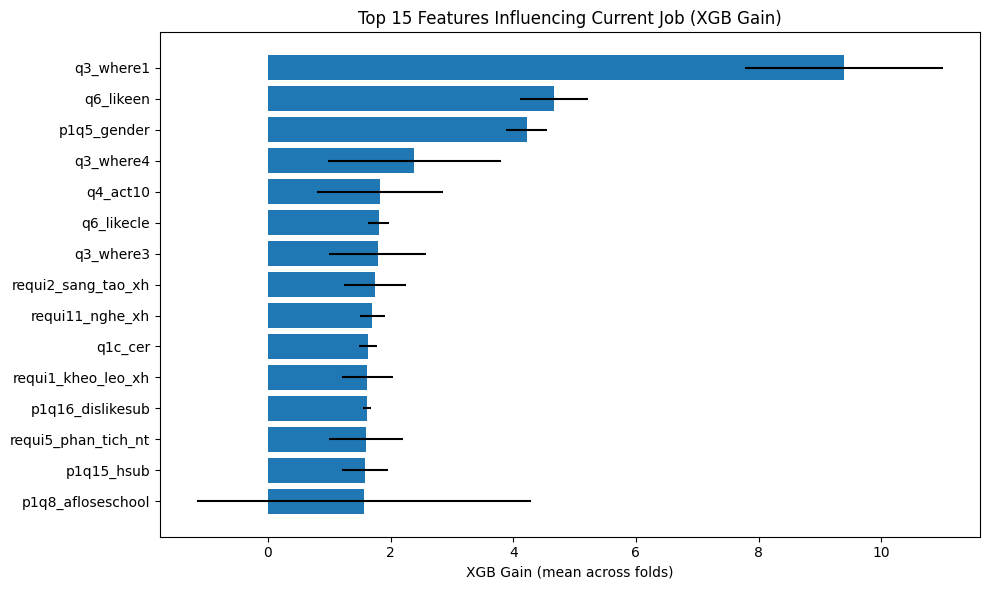

In [6]:
plt.figure(figsize=(10,6))
plt.barh(top15["feature"][::-1], top15["gain_mean"][::-1], xerr=top15["gain_std"][::-1])
plt.xlabel("XGB Gain (mean across folds)")
plt.title("Top 15 Features Influencing Current Job (XGB Gain)")
plt.tight_layout()
plt.savefig("top15_feature_gain.png", dpi=200)

    rank              feature  gain_mean  gain_std  vote_count_top15  \
0      1            q3_where1   9.386898  1.614932                 3   
1      2            q6_likeen   4.663487  0.549097                 3   
2      3          p1q5_gender   4.222210  0.334914                 3   
3      4            q3_where4   2.388896  1.414014                 2   
4      5             q4_act10   1.832946  1.030012                 2   
5      6           q6_likecle   1.804085  0.169989                 3   
6      7            q3_where3   1.789531  0.789490                 2   
7      8   requi2_sang_tao_xh   1.745937  0.499533                 2   
8      9      requi11_nghe_xh   1.703526  0.205480                 3   
9     10              q1c_cer   1.636866  0.145252                 3   
10    11   requi1_kheo_leo_xh   1.619107  0.418508                 2   
11    12     p1q16_dislikesub   1.611107  0.066450                 3   
12    13  requi5_phan_tich_nt   1.599118  0.596623              

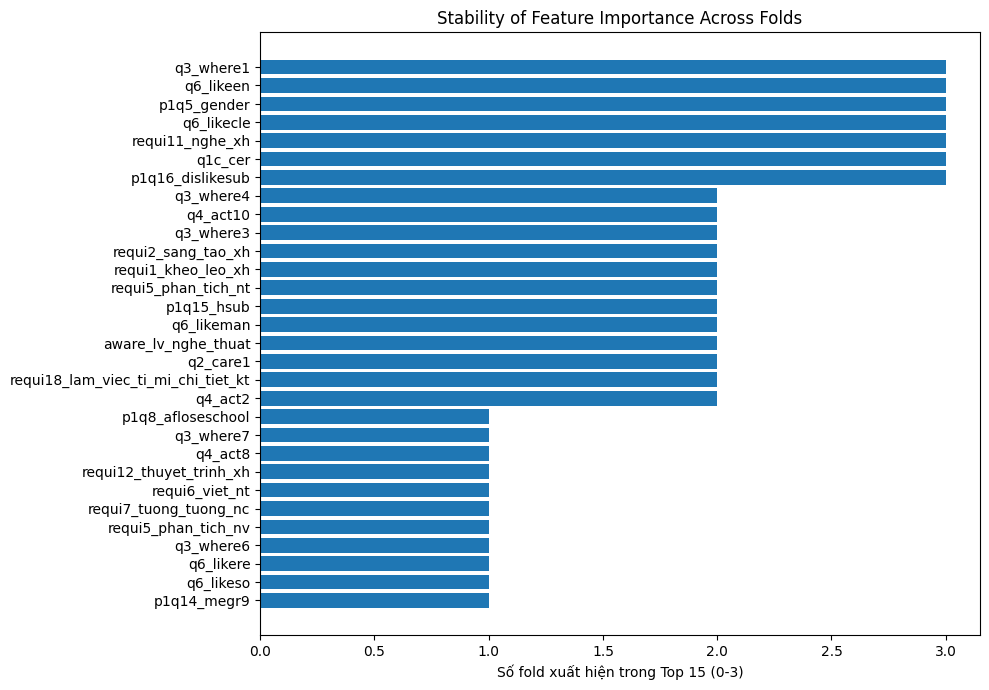

In [7]:
# Stability plot (top 30 by stability then gain)
stab = gain_agg.sort_values(["vote_count_top15","gain_mean"], ascending=[False, False]).head(30)
plt.figure(figsize=(10,7))
plt.barh(stab["feature"][::-1], stab["vote_count_top15"][::-1])
plt.xlabel("Số fold xuất hiện trong Top 15 (0-3)")
plt.title("Stability of Feature Importance Across Folds")
plt.tight_layout()
plt.savefig("feature_stability_top30.png", dpi=200)

print(top15[["rank","feature","gain_mean","gain_std","vote_count_top15","avg_rank_in_top15"]])

# 🌟 Phân Tích Đặc Trưng Quan Trọng (Top Feature Importance)

Dựa trên kết quả mô hình, dưới đây là các biến có mức độ đóng góp cao nhất và ổn định nhất đối với việc dự báo nghề nghiệp.

### 🏆 Top 3 Biến Nổi Bật Nhất

1.  **`q3_where1` (Tiếp cận thực tế)**
    * **Mô tả:** Mức độ tham gia học tập, thực hành kỹ năng nghề và tham quan cơ sở (thuộc nhóm Câu 3).
    * **💡 Insight:** Việc được tiếp cận sớm với cơ sở giáo dục và hoạt động hướng nghiệp ngay từ cấp THCS có mối liên hệ rõ rệt với nghề nghiệp hiện tại.

2.  **`q6_likeen` (Sở thích nghề nghiệp)**
    * **Mô tả:** Mức độ yêu thích đối với các nhóm nghề (thuộc nhóm Câu 6).
    * **💡 Insight:** Đây là yếu tố "gieo mầm" quan trọng. Việc định hướng sở thích từ sớm giúp học sinh tự nhận thức được đam mê của bản thân.

3.  **`p1q5_gender` (Giới tính)**
    * **Mô tả:** Thông tin nhân khẩu học về giới tính.
    * **💡 Insight:** Phản ánh thực tế về sự phân bố nghề nghiệp đặc thù theo giới tính trong xã hội.

---

### 📌 Các Nhóm Biến Quan Trọng Khác (Top 15)

Ngoài Top 3, các biến sau cũng đóng góp đáng kể vào hiệu suất mô hình:

* **Nhóm `requi*` (Nhận thức & Kỹ năng nghề) Câu 7:**
    * Sự xuất hiện của nhóm biến này trong Top 15 cho thấy tầm quan trọng của việc **hiểu rõ yêu cầu nghề nghiệp**. Học sinh càng nắm rõ kỹ năng cần thiết, định hướng nghề càng chính xác.
* **`q1c_cer` (Chứng chỉ nghề):**
    * Loại chứng chỉ nghề mà học sinh đạt được (Giỏi/Khá/Trung bình...).
* **`p1q8_afloseschool` (Lựa chọn sau THCS):**
    * Quyết định về hướng đi ngay sau khi tốt nghiệp THCS (ví dụ: học tiếp THPT, học nghề, hay đi làm...).

In [8]:
import pickle
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    balanced_accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix
)

DATA_PATH = "dataset_THCS_only_filtered.csv"
FOLDS_PATH = "cv_outputs/cv_folds.pkl"
TARGET = "p1q9_job_current"

# Load data
df = pd.read_csv(DATA_PATH)
X = df.drop(columns=[TARGET])
y = df[TARGET].astype(int)

# Load CV folds (đã chuẩn bị sẵn)
with open(FOLDS_PATH, "rb") as f:
    folds = pickle.load(f)

print("Data shape:", X.shape)
print("Class distribution:\n", y.value_counts().sort_index())


Data shape: (759, 183)
Class distribution:
 p1q9_job_current
0    398
1    141
2     92
3    111
4     14
5      3
Name: count, dtype: int64


In [9]:
rf_base_params = dict(
    n_estimators=800,
    max_depth=None,
    min_samples_leaf=2,
    min_samples_split=6,
    max_features="sqrt",
    class_weight="balanced_subsample",
    bootstrap=True,
    n_jobs=-1,
    random_state=42,
)

def run_cv_rf(rf_params, tag=""):
    fold_results = []

    for fold in folds:
        tr_idx = fold["train_idx"]
        va_idx = fold["val_idx"]

        X_tr, y_tr = X.iloc[tr_idx], y.iloc[tr_idx]
        X_va, y_va = X.iloc[va_idx], y.iloc[va_idx]

        model = RandomForestClassifier(**rf_params)
        model.fit(X_tr, y_tr)

        pred = model.predict(X_va)

        bal_acc = balanced_accuracy_score(y_va, pred)
        f1_mac = f1_score(y_va, pred, average="macro")

        print("\n" + "=" * 80)
        print(f"[{tag}] FOLD {fold['fold']}")
        print(f"balanced_accuracy: {bal_acc:.4f}")
        print(f"f1_macro:         {f1_mac:.4f}")
        print("classification_report:")
        print(classification_report(y_va, pred, digits=4))
        print("confusion_matrix:")
        print(confusion_matrix(y_va, pred))

        fold_results.append((bal_acc, f1_mac))

    print("\n" + "#" * 80)
    print(f"[{tag}] MEAN RESULTS")
    print("balanced_accuracy =", np.mean([r[0] for r in fold_results]))
    print("f1_macro          =", np.mean([r[1] for r in fold_results]))


# === RUN BASELINE ===
run_cv_rf(rf_base_params, tag="RF_BASELINE")



[RF_BASELINE] FOLD 0
balanced_accuracy: 0.3471
f1_macro:         0.3330
classification_report:
              precision    recall  f1-score   support

           0     0.8516    0.8195    0.8352       133
           1     0.5217    0.7660    0.6207        47
           2     0.3158    0.2000    0.2449        30
           3     0.2973    0.2973    0.2973        37
           4     0.0000    0.0000    0.0000         5
           5     0.0000    0.0000    0.0000         1

    accuracy                         0.6403       253
   macro avg     0.3311    0.3471    0.3330       253
weighted avg     0.6255    0.6403    0.6269       253

confusion_matrix:
[[109   3   8  13   0   0]
 [  3  36   1   7   0   0]
 [ 10   8   6   6   0   0]
 [  5  18   3  11   0   0]
 [  1   3   1   0   0   0]
 [  0   1   0   0   0   0]]


c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave


[RF_BASELINE] FOLD 1
balanced_accuracy: 0.3605
f1_macro:         0.3475
classification_report:
              precision    recall  f1-score   support

           0     0.8254    0.7879    0.8062       132
           1     0.5362    0.7872    0.6379        47
           2     0.4091    0.2903    0.3396        31
           3     0.3056    0.2973    0.3014        37
           4     0.0000    0.0000    0.0000         5
           5     0.0000    0.0000    0.0000         1

    accuracy                         0.6364       253
   macro avg     0.3460    0.3605    0.3475       253
weighted avg     0.6251    0.6364    0.6248       253

confusion_matrix:
[[104   8   5  15   0   0]
 [  3  37   2   5   0   0]
 [ 12   5   9   5   0   0]
 [  4  16   6  11   0   0]
 [  3   2   0   0   0   0]
 [  0   1   0   0   0   0]]


c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave


[RF_BASELINE] FOLD 2
balanced_accuracy: 0.3518
f1_macro:         0.3408
classification_report:
              precision    recall  f1-score   support

           0     0.8400    0.7895    0.8140       133
           1     0.5000    0.7234    0.5913        47
           2     0.4231    0.3548    0.3860        31
           3     0.2647    0.2432    0.2535        37
           4     0.0000    0.0000    0.0000         4
           5     0.0000    0.0000    0.0000         1

    accuracy                         0.6285       253
   macro avg     0.3380    0.3518    0.3408       253
weighted avg     0.6250    0.6285    0.6221       253

confusion_matrix:
[[105   9   7  12   0   0]
 [  3  34   4   6   0   0]
 [  8   7  11   5   0   0]
 [  6  18   4   9   0   0]
 [  2   0   0   2   0   0]
 [  1   0   0   0   0   0]]

################################################################################
[RF_BASELINE] MEAN RESULTS
balanced_accuracy = 0.35313867872839083
f1_macro          = 0.340444606

c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave

# CVAE - Conditional VAE